# Diesel Truck Data (Unsupervised Learning_PCA)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import numpy as np

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [3]:
#Uploading cleaned and preprocessed dataset
df_2017_2018_selected_preprocessed = pd.read_parquet('df_2017_2018_selected_preprocessed.parquet')

In [4]:
##Unsupervised Learning dataset
catogorical_columns = ['TrSelGr','TransCurGear', 'TransTorqConvLockupEngaged']
unsupervised_df = df_2017_2018_selected_preprocessed.drop(catogorical_columns, axis = 1)
unsupervised_df =  unsupervised_df[(unsupervised_df.index > '2018-01-01') & (unsupervised_df.index < '2019-01-01')]
#unsupervised_df

In [5]:
# Apply RobustScaler for training data
#scaler = MinMaxScaler()
scaler = RobustScaler()

unsupervised_df_scaled = pd.DataFrame(scaler.fit_transform(unsupervised_df), columns=unsupervised_df.columns,
                       index=unsupervised_df.index)

## PCA

In [6]:
def find_best_pca_components(df):##keep 95 percent variance
    
    for n_components in range (2, 7): 
        # Decide on the number of components.
        pca = PCA(n_components).fit(df)

        # Transform the scaled data to the new PCA space
        transformed_df = pca.transform(df)

        if pca.explained_variance_ratio_.sum() > 0.95:
            best_n_components = n_components
            best_transformed_df = transformed_df
            best_pca = pca
            break

    # The result 'df_selected_pca' is an array with the new principal component features
    pca_df = pd.DataFrame(best_transformed_df, columns=[f'PC{i+1}' for i in range(best_transformed_df.shape[1])])        

    #print("Best number of components:", best_n_components)
    #print("Explained variance ratio:", best_pca.explained_variance_ratio_)
    
    return pca_df, best_n_components, best_pca.explained_variance_ratio_

In [7]:
pca = find_best_pca_components(unsupervised_df_scaled)
pca_df = pca[0]
clomuns_pca = ['PC1', 'PC2', 'PC3']

pca_df = pca_df[clomuns_pca]
#pca_df

## Isolation Forest

In [8]:
##negative decision function values in the range of -1 to 0 are more likely to be an outlier, 
##while positive values in the range of 0 to 1 are more likely to be an inlier.
## Decision function values are multiply by -1 to recognize outliers better in plots. 
def detect_outliers_with_isolation_forest(df, n_estimators):
   
    # Initialize the Isolation Forest model
    isolation_forest = IsolationForest(n_estimators=n_estimators, contamination='auto', random_state=42)
    isolation_forest.fit(df)
    
    # Predict anomalies (-1 for outliers and 1 for inliers)
    #anomalies = isolation_forest.predict(df)
    #outliers_isolated_forest = anomalies[anomalies==-1]   
        
    # Predict decision function values 
    decision_function = -1*(isolation_forest.decision_function(df))
    
    # Select a threshold 
    threshold = np.percentile(decision_function, 95)  # 95th percentile

    # Identify outliers based on the threshold
    outliers_decision_function = decision_function > threshold
       
    # Print the number of outliers detected 
      
    num_outliers_decision_function = sum(outliers_decision_function)
   
    print("Number of outliers detected with decision function:", num_outliers_decision_function)
    
    return (decision_function, outliers_decision_function, num_outliers_decision_function, threshold)

### Sensitivity Analysis for Isolation Forest 

Number of outliers detected with decision function: 6157
Number of outliers detected with decision function: 6157
Number of outliers detected with decision function: 6157
Number of outliers detected with decision function: 6157


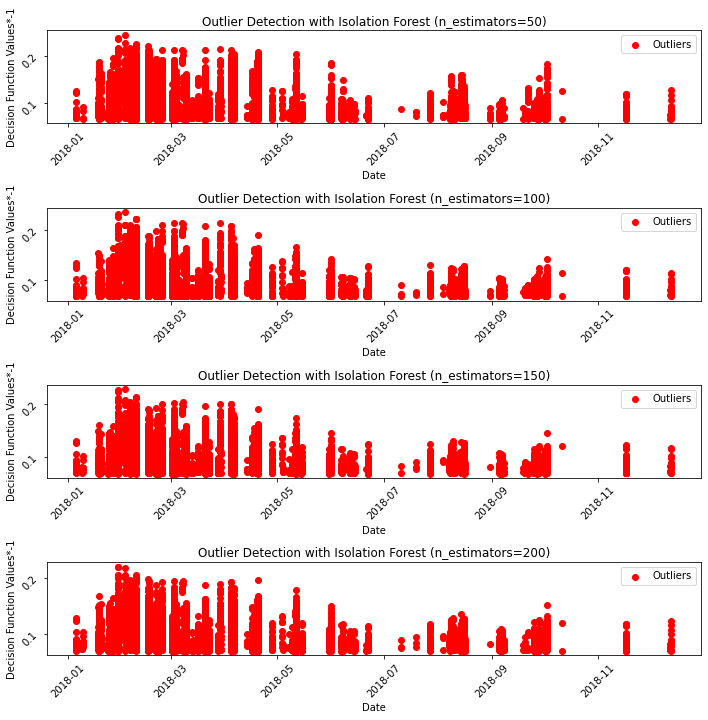

In [9]:
n_estimators = [50, 100, 150, 200]

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, figsize=(10, 10))

for i, n_estimator in enumerate(n_estimators):
    # Detect outliers with Isolation Forest
    isolation_forest_function = detect_outliers_with_isolation_forest(pca_df, n_estimator)
    decision_function = isolation_forest_function[0]
    outliers_decision_function = isolation_forest_function[1]
    
        
    # Create scatter plot for data
    axs[i].scatter(unsupervised_df_scaled.index[outliers_decision_function], decision_function[outliers_decision_function], 
                   c='r', label='Outliers')    
    axs[i].set_xlabel('Date')  
    axs[i].set_ylabel("Decision Function Values*-1")
    axs[i].set_title(f'Outlier Detection with Isolation Forest (n_estimators={n_estimator})')
    axs[i].tick_params(labelrotation=45)    
    axs[i].legend()
    
plt.tight_layout()
plt.rc('font', family='Arial', size=12)
plt.show()

## Kmeans Clustering

In [10]:
def detect_outliers_with_kmeans(df):
  
    # Initialize the KMeans clustering model
    silhouette_scores = []
    for i in range(2, 4):  # 8
        kmeans = KMeans(n_clusters=i, random_state=42).fit(df)
        silhouette_kmeans = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(silhouette_kmeans)
        if silhouette_kmeans == max(silhouette_scores):
            best_silhouette_scores = silhouette_kmeans
            best_n_clusters = i
            best_kmeans = kmeans

    # Assign cluster labels 
    clusters = best_kmeans.labels_
    

    # Identify outliers based on distance to cluster centroids
    # Calculate distances from each data point to its nearest cluster centroid
    
    centroid_distances = best_kmeans.transform(df)
    
    # Determine a suitable threshold for outlier detection (e.g., 95th percentile)
    threshold = np.percentile(centroid_distances, 95)

    outliers = centroid_distances.max(axis=1) > threshold
    
    # Evaluate performance
    # Print the number of outliers detected 
    num_outliers = sum(outliers)
    
    print("Number of outliers detected:", num_outliers)
    print("best_n_clusters:", best_n_clusters)
    print('best_silhouette_scores:', best_silhouette_scores)
      
    return (centroid_distances, outliers, num_outliers, threshold)

### Sensitivity Analysis for Kmeans

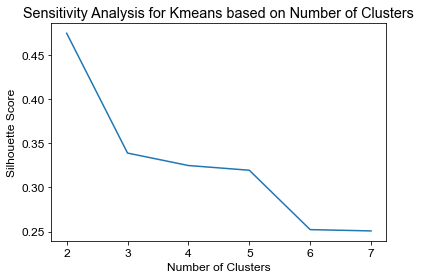

In [11]:
silhouette_scores = []

# Test different number of clusters
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(unsupervised_df_scaled)
    silhouette_scores.append(silhouette_score(unsupervised_df_scaled, kmeans.labels_))

# Plot the Silhouette Score graph
plt.plot(range(2, 8), silhouette_scores)
plt.title('Sensitivity Analysis for Kmeans based on Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.rc('font', family='Arial', size=12)
plt.show()

### Detetcted Outliers With Kmeans

Number of outliers detected: 12314
best_n_clusters: 2
best_silhouette_scores: 0.5248614013718643


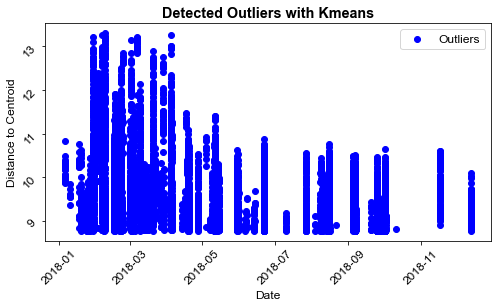

In [12]:
kmeans_function = detect_outliers_with_kmeans(pca_df)

centroid_distances = kmeans_function[0]
outliers_kmeans = kmeans_function[1]
num_outliers_kmeans = kmeans_function[2]
threshold_kmeans = kmeans_function[3]

# Create scatter plot 
plt.figure(figsize=(8, 4))
plt.scatter(unsupervised_df_scaled.index[outliers_kmeans], centroid_distances.max(axis=1)[outliers_kmeans], 
            c='blue', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Distance to Centroid')
plt.title('Detected Outliers with Kmeans', fontweight='bold')
plt.legend()
plt.tick_params(labelrotation=45)
plt.rc('font', family='Arial', size=12)
plt.show()

## Mahalanobis Distances

In [13]:
def detect_outliers_with_mahalanobis(df):

    # Fit Minimum Covariance Determinant (MCD) estimator
    mcd_estimator = MinCovDet()
    mcd_estimator.fit(df)

    # Calculate Mahalanobis Distances 
    mahalanobis_distances = mcd_estimator.mahalanobis(df)
    
    #Identify outliers based on Mahalanobis distances
    threshold = np.percentile(mahalanobis_distances, 95)

    outliers = mahalanobis_distances > threshold       

    # Evaluate performance
    # Print the number of outliers detected 
    num_outliers = sum(outliers)
   
    print("Number of outliers detected:", num_outliers)
       
    return (mahalanobis_distances, outliers, num_outliers, threshold)

Number of outliers detected: 6157


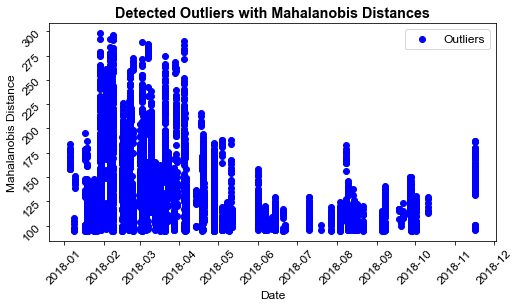

In [14]:
mahalanobis_function = detect_outliers_with_mahalanobis(pca_df)

mahalanobis_distances = mahalanobis_function[0]
outliers_mahalanobis = mahalanobis_function[1]
num_outliers_mahalanobis = mahalanobis_function[2]
threshold_mahalanobis = mahalanobis_function[3]

# Create scatter plot 
plt.figure(figsize=(8, 4))
plt.scatter(unsupervised_df_scaled.index[outliers_mahalanobis], mahalanobis_distances[outliers_mahalanobis], 
            c='blue', label='Outliers')
plt.xlabel('Date')
plt.ylabel("Mahalanobis Distance")
plt.title('Detected Outliers with Mahalanobis Distances', fontweight='bold')
plt.legend()
plt.tick_params(labelrotation=45)
plt.rc('font', family='Arial', size=12)
plt.show()


## Visualization of Outliers with Threshold

In [15]:
isolation_forest_function = detect_outliers_with_isolation_forest(pca_df, 100)
decision_function = isolation_forest_function[0]
outliers_decision_function = isolation_forest_function[1]
num_outliers_decision_function = isolation_forest_function[2]
threshold_isolated_forest = isolation_forest_function[3]

Number of outliers detected with decision function: 6157


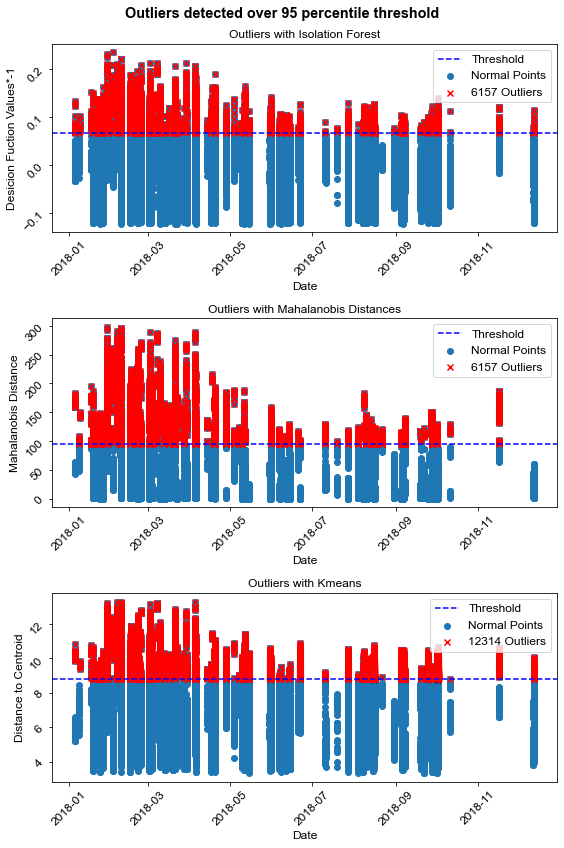

In [16]:
# Create 3 subplots
fig, axs = plt.subplots( 3, figsize=(8, 12))

# Isolation Forest
axs[0].scatter(unsupervised_df_scaled.index, decision_function, label='Normal Points')
axs[0].scatter(unsupervised_df_scaled.index[outliers_decision_function], decision_function[outliers_decision_function], 
               color='red', marker='x', label=f'{num_outliers_decision_function} Outliers')
axs[0].axhline(y=threshold_isolated_forest, color='b', linestyle='--', label='Threshold')
axs[0].set_xlabel('Date')
axs[0].set_ylabel("Desicion Fuction Values*-1")
axs[0].set_title('Outliers with Isolation Forest', fontsize=12, fontfamily='Arial')
axs[0].tick_params(labelrotation=45)
axs[0].legend()


# Mahalanobis Distance
axs[1].scatter(unsupervised_df_scaled.index, mahalanobis_distances, label='Normal Points')
axs[1].scatter(unsupervised_df_scaled.index[outliers_mahalanobis], mahalanobis_distances[outliers_mahalanobis], 
               color='red', marker='x', label=f'{num_outliers_mahalanobis} Outliers')
axs[1].axhline(y=threshold_mahalanobis, color='b', linestyle='--', label='Threshold')
axs[1].set_xlabel('Date')
axs[1].set_ylabel("Mahalanobis Distance")
axs[1].set_title('Outliers with Mahalanobis Distances', fontsize=12, fontfamily='Arial')
axs[1].tick_params(labelrotation=45)
axs[1].legend()

#  K-Means Clustering
axs[2].scatter(unsupervised_df_scaled.index, centroid_distances.max(axis=1), label='Normal Points')
axs[2].scatter(unsupervised_df_scaled.index[outliers_kmeans], centroid_distances.max(axis=1)[outliers_kmeans], 
               color='red', marker='x', label=f'{num_outliers_kmeans} Outliers')
axs[2].axhline(y=threshold_kmeans, color='b', linestyle='--', label='Threshold')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Distance to Centroid')
axs[2].set_title('Outliers with Kmeans', fontsize=12, fontfamily='Arial')
axs[2].tick_params(labelrotation=45)
axs[2].legend()

plt.suptitle('Outliers detected over 95 percentile threshold', fontweight='bold')

plt.tight_layout()
plt.rc('font', family='Arial', size=12)
plt.show()

## Distribution of Detected Outliers with Anomaly Scores

In [17]:
#Distribution information help us to define our threshold better.
#Based on our business purpose, the threshold can be adjusted. 

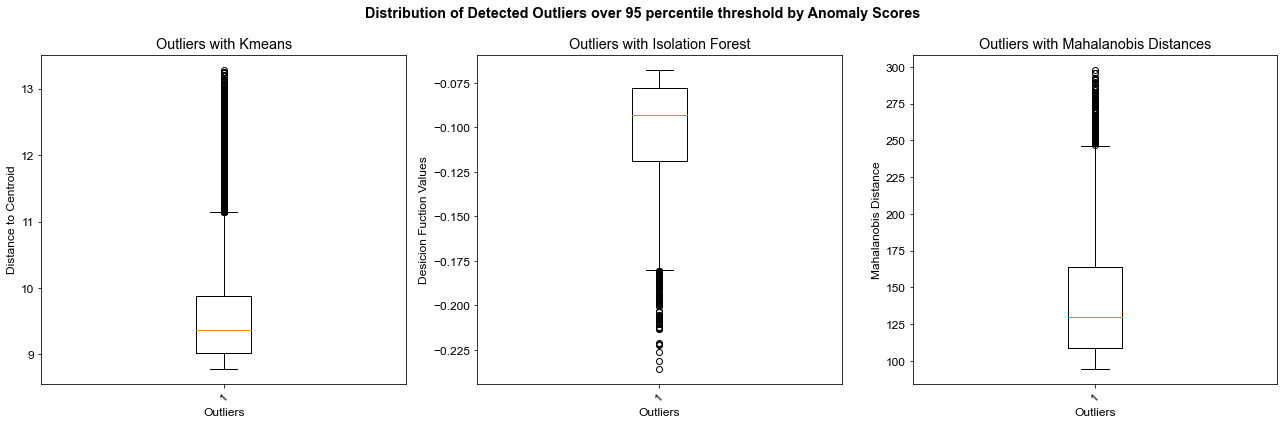

In [18]:
# Plot settings
plt.figure(figsize=(18, 6))

#  K-Means Clustering
plt.subplot(1, 3, 1)
plt.boxplot(centroid_distances.max(axis=1)[outliers_kmeans])
plt.title('Outliers with Kmeans')
plt.xlabel('Outliers')
plt.ylabel('Distance to Centroid')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)

# Isolation Forest
plt.subplot(1, 3, 2)
plt.boxplot(-1*(decision_function[outliers_decision_function]))
plt.title('Outliers with Isolation Forest')
plt.xlabel('Outliers')
plt.ylabel('Desicion Fuction Values')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)

# Mahalanobis Distance
plt.subplot(1, 3, 3)
plt.boxplot(mahalanobis_distances[outliers_mahalanobis])
plt.title('Outliers with Mahalanobis Distances')
plt.xlabel('Outliers')
plt.ylabel('Mahalanobis Distance')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)

plt.suptitle('Distribution of Detected Outliers over 95 percentile threshold by Anomaly Scores', fontweight='bold')

plt.tight_layout()
plt.show()

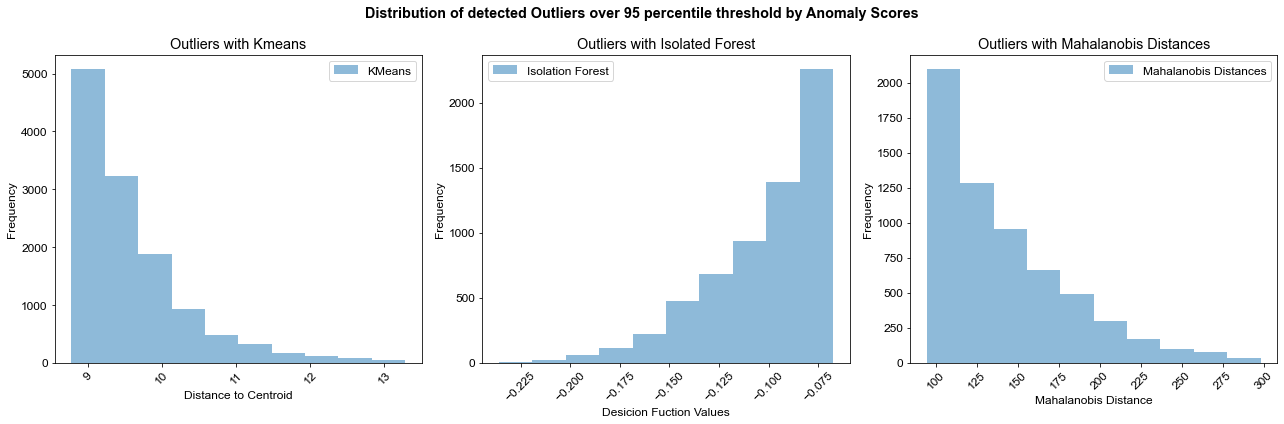

In [19]:
# Plot settings
plt.figure(figsize=(18, 6))

#  K-Means Clustering
plt.subplot(1, 3, 1)
plt.hist(centroid_distances.max(axis=1)[outliers_kmeans], alpha=0.5, label='KMeans')
plt.title('Outliers with Kmeans')
plt.xlabel('Distance to Centroid')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()


# Isolation Forest
plt.subplot(1, 3, 2)
plt.hist(-1*(decision_function[outliers_decision_function]), alpha=0.5, label='Isolation Forest')
plt.title('Outliers with Isolated Forest')
plt.xlabel('Desicion Fuction Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

# Mahalanobis Distance
plt.subplot(1, 3, 3)
plt.hist(mahalanobis_distances[outliers_mahalanobis], alpha=0.5, label='Mahalanobis Distances')
plt.title('Outliers with Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

plt.suptitle('Distribution of detected Outliers over 95 percentile threshold by Anomaly Scores', fontweight='bold')

plt.tight_layout()
plt.show()

## Patterns in Detected Outliers over Time

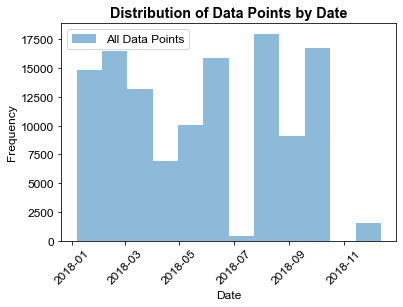

In [20]:
#All Data Points
plt.hist(unsupervised_df_scaled.index, bins=12, alpha=0.5, label='All Data Points')
plt.title('Distribution of Data Points by Date', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

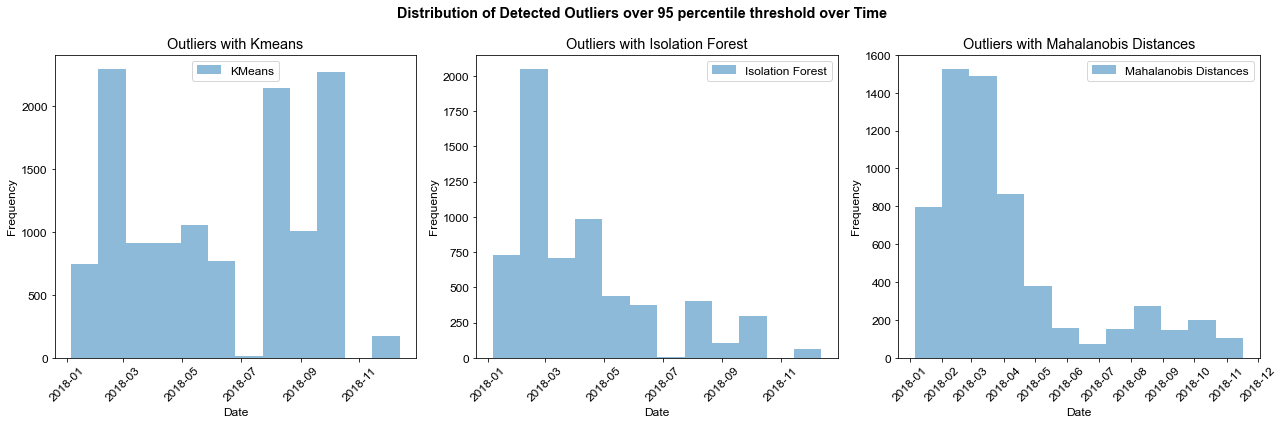

In [21]:
# Plot settings
plt.figure(figsize=(18, 6))

#  K-Means Clustering
plt.subplot(1, 3, 1)
plt.hist(unsupervised_df_scaled.index[outliers_kmeans], bins=12, alpha=0.5, label='KMeans')
plt.title('Outliers with Kmeans')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

# Isolation Forest
plt.subplot(1, 3, 2)
plt.hist(unsupervised_df_scaled.index[outliers_decision_function], bins=12, alpha=0.5, label='Isolation Forest')
plt.title('Outliers with Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

# Mahalanobis Distance
plt.subplot(1, 3, 3)
plt.hist(unsupervised_df_scaled.index[outliers_mahalanobis], bins=12, alpha=0.5, label='Mahalanobis Distances')
plt.title('Outliers with Mahalanobis Distances')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.rc('font', family='Arial', size=12)
plt.legend()

plt.suptitle('Distribution of Detected Outliers over 95 percentile threshold over Time', fontweight='bold')

plt.tight_layout()
plt.show()

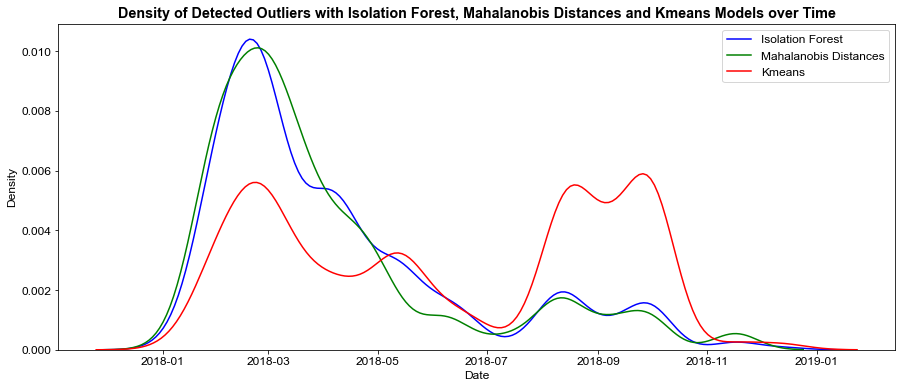

In [22]:
plt.figure(figsize=(15, 6))

# Isolation Forest
sns.kdeplot(unsupervised_df_scaled.index[outliers_decision_function], color='blue', label='Isolation Forest')

# Mahalanobis Distance
sns.kdeplot(unsupervised_df_scaled.index[outliers_mahalanobis], color='green', label='Mahalanobis Distances')

#  K-Means Clustering
sns.kdeplot(unsupervised_df_scaled.index[outliers_kmeans], color='red', label='Kmeans')

plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Detected Outliers with Isolation Forest, Mahalanobis Distances and Kmeans Models over Time', fontweight='bold')
plt.rc('font', family='Arial', size=12)
plt.legend()

plt.show()